#### Example: The Lotka-Volterra Predator-Prey model

Imports to get the model up and running

In [1]:
import numpy as np
import gillespy2
from gillespy2.solvers.stochkit import StochKitSolver

Model definition

In [2]:
class LotkaVolterra(gillespy2.Model):
    def __init__(self, parameter_values=[1.0, 0.005, 0.6]):
        # initialize Model
        gillespy2.Model.__init__(self, name="Lotka-Volterra")

        # parameters
        params = parameter_values
        rate1 = gillespy2.Parameter(name='rate1', expression=params[0])
        rate2 = gillespy2.Parameter(name='rate2', expression=params[1])
        rate3 = gillespy2.Parameter(name='rate3', expression=params[2])
        self.add_parameter([rate1, rate2, rate3])

        # Species
        A = gillespy2.Species(name='A', initial_value=50)
        B = gillespy2.Species(name='B', initial_value=100)
        self.add_species([A, B])

        # reactions
        r1 = gillespy2.Reaction(name="r1", reactants={A: 1}, products={A: 2},
                                rate=rate1)

        r2 = gillespy2.Reaction(name="r2", reactants={A: 1, B: 1}, products={B: 2},
                                rate=rate2)

        r3 = gillespy2.Reaction(name="r3", reactants={B: 1}, products={},
                                rate=rate3)
        self.add_reaction([r1, r2, r3])
        self.timespan(np.linspace(0, 30, 30))

Instantiate the model and test responses

In [3]:
model = LotkaVolterra()

In [4]:
results = model.run(solver=StochKitSolver, show_labels=True, number_of_trajectories=1)

Plot responses

In [5]:
#%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

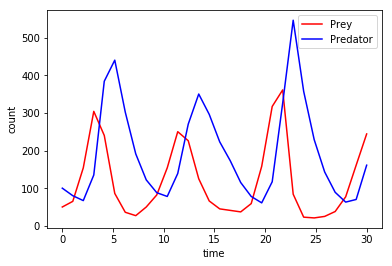

In [6]:
plt.plot(results[0]['time'], results[0]['A'],'-r', label='Prey')
plt.plot(results[0]['time'], results[0]['B'],'-b', label='Predator')
plt.xlabel('time')
plt.ylabel('count')
plt.legend(loc='best')

Create a dataset for inference

In [7]:
results = model.run(solver=StochKitSolver, show_labels=False, number_of_trajectories=100)
# reshape
fixed_data = np.asarray([x.T for x in results])
# and remove timepoints array
fixed_data = fixed_data[:,1:, :]

Verify we have the data in correct dimensionality (num trajs/time series x num species x num time points/time steps)

In [8]:
fixed_data.shape

(100, 2, 30)

In [9]:
num_timestamps = fixed_data.shape[2]

Set up a dask cluster (or use multiprocessing)

In [10]:
#from dask.distributed import Client

In [11]:
#c = Client()

In [12]:
#c

Imports for inference

In [13]:
from sciope.utilities.priors import uniform_prior
from sciope.inference import abc_inference
from sklearn.metrics import mean_absolute_error
from sciope.utilities.summarystats import auto_tsfresh
from sciope.utilities.distancefunctions import naive_squared
from tsfresh.feature_extraction.settings import MinimalFCParameters

Define a simulator to be used as part of the inference task

In [14]:
# simulator
def sim_lv(param):
    lv_model = LotkaVolterra(parameter_values=param)
    sim_results = lv_model.run(solver=StochKitSolver, show_labels=False, number_of_trajectories=1)
    tot_res = np.asarray([x.T for x in sim_results]) # reshape to (N, S, T)  
    tot_res = tot_res[:,1:, :] # should not contain timepoints
    tot_res = tot_res.reshape((1, 2, num_timestamps))
    return tot_res

Set up inference objects

In [15]:
dmin = [0.7, 0.001, 0.5]
dmax = [1.2, 0.005, 0.8]
lv_prior = uniform_prior.UniformPrior(np.asarray(dmin), np.asarray(dmax))

In [16]:
# summary statistics 
summ_func = auto_tsfresh.SummariesTSFRESH(corrcoef=True)

# distance function
ns = naive_squared.NaiveSquaredDistance()

In [17]:
abc_instance = abc_inference.ABC(fixed_data, sim_lv, epsilon=0.05, prior_function=lv_prior, 
                                 summaries_function=summ_func.compute, distance_function=ns, use_logger=True)


2019-08-27 10:18:33,608 	 [INFO     | abc_inference.py:91] : Approximate Bayesian Computation initialized


Sciope logger is now ready. Log directory is /var/folders/d4/4nl8s_w539nbh_1f9y473q240000gn/T/Sciope_logs


In [18]:
abc_instance.compute_fixed_mean(chunk_size=2)

Perform inference

In [19]:
abc_results = abc_instance.infer(num_samples=50, batch_size=10, chunk_size=2)


2019-08-27 10:18:33,744 	 [INFO     | abc_inference.py:257] : running in parallel mode

2019-08-27 10:18:34,017 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.16337708e+00 1.08215605e-03 5.41902962e-01]

2019-08-27 10:18:34,019 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

2019-08-27 10:18:34,021 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.96644683 0.00327323 0.56953825]

2019-08-27 10:18:34,024 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.16381344e-02 5.51097446e-03 1.33360631e-02 1.06292907e-03
 1.00000000e+00 1.33360631e-02 6.21981407e-01 9.82534003e-03
 5.46798538e-03 1.11188427e-02 7.74285855e-04 6.99678217e-01
 1.11188427e-02 8.62782090e-03 1.31331287e-02]

2019-08-27 10:18:34,028 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.98377507 0.0


2019-08-27 10:18:34,380 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.84295599 0.00357918 0.61901153]

2019-08-27 10:18:34,381 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [3.22833773e-02 2.72216431e-02 3.33663500e-02 4.23742681e-03
 3.76617787e-01 3.33663500e-02 2.13966044e-04 1.73174397e-02
 1.46502030e-02 2.50829486e-03 1.65113100e-03 6.61834693e-01
 2.50829486e-03 8.27002429e-03 2.01073439e-02]

2019-08-27 10:18:34,383 	 [INFO     | abc_inference.py:257] : running in parallel mode

2019-08-27 10:18:34,669 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.86007814 0.00344922 0.5101842 ]

2019-08-27 10:18:34,671 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [0.02947172 0.02771479 0.00100017 0.00373084 0.57819477 0.00100017
 0.5448986  0.02416352 0.02771164 0.00130621 0.00261126 1.
 0.00130621 0.01736856 1.        ]

2019-08-27 10:18:34,


2019-08-27 10:18:35,011 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.36490349e-03 5.99216448e-04 5.24982240e-03 5.67834121e-05
 2.13538896e-01 5.24982240e-03 3.23555083e-02 2.39769213e-03
 1.21151261e-03 5.68028324e-03 1.27932978e-04 8.92254868e-01
 5.68028324e-03 9.31041472e-03 1.83662191e-02]

2019-08-27 10:18:35,013 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.07510184 0.00116155 0.74672628]

2019-08-27 10:18:35,014 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [0.98810693 0.69962045 1.         0.97867088 0.50622007 1.
 0.0738107  1.         1.         0.78853194 1.         0.36051164
 0.78853194 0.01203556 0.00344918]

2019-08-27 10:18:35,016 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.91340834 0.00352837 0.75318757]

2019-08-27 10:18:35,017 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [0


2019-08-27 10:18:35,607 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [5.12988035e-04 3.40328901e-04 1.42425120e-02 1.23469368e-05
 3.93178694e-01 1.42425120e-02 5.79588807e-01 3.50649030e-04
 3.78667832e-04 3.82279722e-03 7.80027197e-06 1.21172370e-01
 3.82279722e-03 1.63146594e-02 3.38034966e-02]

2019-08-27 10:18:35,610 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.83100631 0.00151155 0.55099876]

2019-08-27 10:18:35,612 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [0.10632104 0.06713681 0.18474131 0.01998412 0.06694704 0.18474131
 0.01132787 0.10332047 0.05060786 0.07952414 0.01911183 0.00373882
 0.07952414 0.00135964 0.00246946]

2019-08-27 10:18:35,614 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.70029688 0.00182006 0.70936473]

2019-08-27 10:18:35,616 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance


2019-08-27 10:18:36,203 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [0.09374008 0.12413104 0.00122029 0.01627986 0.5255405  0.00122029
 0.79420288 0.07911038 0.09654488 0.00223401 0.01241696 1.
 0.00223401 0.09290444 0.80126188]

2019-08-27 10:18:36,205 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.09623521 0.00242666 0.79963689]

2019-08-27 10:18:36,206 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [7.39079079e-02 3.94056507e-02 1.96055493e-01 1.11103695e-02
 4.40119321e-04 1.96055493e-01 6.76523617e-01 6.06066532e-02
 3.69428079e-02 8.84063829e-02 8.14079283e-03 5.27428708e-02
 8.84063829e-02 3.39289752e-02 4.73402043e-02]

2019-08-27 10:18:36,209 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.84645729 0.00335858 0.55196562]

2019-08-27 10:18:36,211 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [3


2019-08-27 10:18:36,818 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.15449707 0.00366042 0.65315868]

2019-08-27 10:18:36,819 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [6.65556078e-04 1.46888792e-03 1.71130877e-02 1.72345028e-05
 4.67664165e-02 1.71130877e-02 4.48233487e-01 1.35127912e-03
 2.39819859e-03 1.98330804e-02 4.30257986e-05 5.73567391e-01
 1.98330804e-02 9.04453357e-02 6.13410044e-02]

2019-08-27 10:18:36,820 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.15365193e+00 1.03876848e-03 7.12722261e-01]

2019-08-27 10:18:36,821 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [0.66587379 0.9021625  0.10119551 0.47606924 0.20374283 0.10119551
 0.79420288 0.42809463 0.56319205 0.05009523 0.21576698 1.
 0.05009523 0.09144536 0.09192563]

2019-08-27 10:18:36,823 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial para


2019-08-27 10:18:37,136 	 [INFO     | abc_inference.py:257] : running in parallel mode

2019-08-27 10:18:37,398 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.94210788 0.00165207 0.65543812]

2019-08-27 10:18:37,400 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [0.19331957 0.08759765 0.36608837 0.05415932 0.09378351 0.36608837
 0.27312602 0.16963762 0.08428627 0.14514609 0.04347817 0.34899253
 0.14514609 0.00087998 0.01633026]

2019-08-27 10:18:37,401 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.0882515  0.00410494 0.54565359]

2019-08-27 10:18:37,402 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.09126612e-03 1.05861375e-03 1.97605017e-04 3.22576377e-05
 1.12404970e-01 1.97605017e-04 5.04909444e-03 2.03055816e-03
 1.72679919e-03 3.64836563e-03 7.18522828e-05 3.29465320e-02
 3.64836563e-03 2.58413873e-03 4.63822554e-03]

2019-08-27 1


2019-08-27 10:18:37,728 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.739131   0.0039626  0.64888716]

2019-08-27 10:18:37,731 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [9.21944405e-04 6.35175520e-04 7.07937382e-03 2.60643052e-05
 1.00290486e-02 7.07937382e-03 1.17011332e-01 1.38576252e-04
 3.62011969e-05 2.94472237e-05 2.20882743e-06 6.43795946e-02
 2.94472237e-05 2.27400792e-03 3.67390202e-02]

2019-08-27 10:18:37,733 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.84333225 0.00309727 0.74990332]

2019-08-27 10:18:37,735 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [6.46525036e-03 1.98040880e-03 7.54112728e-02 3.18757510e-04
 1.00000000e+00 7.54112728e-02 1.00000000e+00 1.70963430e-03
 4.03103677e-04 5.41861738e-03 5.78302567e-05 3.22511103e-02
 5.41861738e-03 6.34728254e-03 2.90022111e-04]

2019-08-27 10:18:37,737 	 [INFO     | a


2019-08-27 10:18:38,314 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [0.28938264 0.28487183 0.15782385 0.10837025 0.20374283 0.15782385
 0.3302671  0.19679134 0.13409289 0.06665646 0.05589787 1.
 0.06665646 0.04255198 0.02149941]

2019-08-27 10:18:38,316 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.85269974 0.00332143 0.65050504]

2019-08-27 10:18:38,318 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.13019496e-02 5.17054471e-03 2.14830056e-02 6.81357755e-04
 5.47900767e-03 2.14830056e-02 1.09630711e-02 6.66324168e-03
 1.56389419e-03 5.44558636e-03 3.34750892e-04 2.21266739e-01
 5.44558636e-03 2.68154022e-05 8.55427002e-04]

2019-08-27 10:18:38,320 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.00126992 0.00275445 0.73874842]

2019-08-27 10:18:38,321 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [0


2019-08-27 10:18:38,906 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [2.18097598e-01 2.20037814e-01 1.21822173e-01 6.65261775e-02
 2.03742830e-01 1.21822173e-01 1.82736034e-02 1.42906761e-01
 1.48968704e-01 8.90385401e-02 3.26216322e-02 6.91371833e-01
 8.90385401e-02 2.55732477e-04 1.29974649e-01]

2019-08-27 10:18:38,910 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.01997377 0.0048337  0.57121707]

2019-08-27 10:18:38,911 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [3.47209144e-04 2.28990158e-04 7.59134716e-06 1.09328424e-05
 1.52428479e-01 7.59134716e-06 1.47731500e-03 1.31094832e-04
 1.53024936e-04 7.06454253e-05 5.24410526e-06 1.76667024e-01
 7.06454253e-05 7.18503545e-04 2.92699055e-03]

2019-08-27 10:18:38,914 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.09007367 0.00128616 0.64864111]

2019-08-27 10:18:38,915 	 [DEBUG    | a


2019-08-27 10:18:39,503 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [0.03420857 0.03515928 0.02105993 0.00336905 0.20374283 0.02105993
 0.00467919 0.03093885 0.03646916 0.0079239  0.00291035 0.95243315
 0.0079239  0.01059961 0.14293042]

2019-08-27 10:18:39,504 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.05753798 0.00356359 0.55142681]

2019-08-27 10:18:39,505 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [5.17230486e-03 1.91229719e-03 3.18968161e-04 2.37025099e-04
 2.03742830e-01 3.18968161e-04 1.10778967e-01 7.60913496e-03
 4.53716397e-03 3.90002050e-04 3.99938245e-04 9.52433153e-01
 3.90002050e-04 7.21349505e-03 4.02405738e-01]

2019-08-27 10:18:39,507 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.98155732 0.00291271 0.62591369]

2019-08-27 10:18:39,509 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance


2019-08-27 10:18:39,821 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [0.04018952 0.03902348 0.00451875 0.00429961 0.20374283 0.00451875
 0.12927251 0.05389063 0.03752753 0.02708588 0.00677618 0.90602534
 0.02708588 0.00416118 0.02712272]

2019-08-27 10:18:39,823 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.07220119 0.00116152 0.78735813]

2019-08-27 10:18:39,824 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [0.81314399 0.47511321 0.83591696 0.68454861 0.1547035  0.83591696
 0.02349763 1.         0.45821779 0.89968196 1.         0.22126674
 0.89968196 0.01100418 0.00253872]

2019-08-27 10:18:39,825 	 [INFO     | abc_inference.py:257] : running in parallel mode

2019-08-27 10:18:40,086 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.11142515e+00 1.08693578e-03 5.37056628e-01]

2019-08-27 10:18:40,087 	 [DEBUG    | abc_inference.py:298] :


2019-08-27 10:18:40,404 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.88885176e-02 1.73029570e-02 2.35676591e-02 1.40649634e-03
 2.03742830e-01 2.35676591e-02 4.59914309e-03 1.15347446e-02
 1.04106783e-02 7.16144489e-03 6.99129133e-04 3.48992531e-01
 7.16144489e-03 7.71373169e-05 1.00122643e-01]

2019-08-27 10:18:40,406 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.70546707 0.00242257 0.50896267]

2019-08-27 10:18:40,407 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [0.01179956 0.00525414 0.02942143 0.00072333 0.01668559 0.02942143
 0.03239981 0.00509186 0.0017521  0.00356486 0.00023196 0.05274287
 0.00356486 0.00035537 0.00966124]

2019-08-27 10:18:40,409 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.85237939 0.00487788 0.60628477]

2019-08-27 10:18:40,411 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance


2019-08-27 10:18:40,990 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [0.00644101 0.00264705 0.02007537 0.00031716 0.00025489 0.02007537
 0.03738597 0.00305089 0.00068915 0.00309227 0.00011928 0.02478692
 0.00309227 0.0009527  0.00493072]

2019-08-27 10:18:40,992 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.88172001 0.0018166  0.74512298]

2019-08-27 10:18:40,993 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [0.09647624 0.04341018 0.19567389 0.01705778 0.28682321 0.19567389
 0.10862041 0.06838713 0.03045457 0.08688976 0.00979682 0.04226518
 0.08688976 0.0230306  0.00827319]

2019-08-27 10:18:40,994 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.05504813 0.00269062 0.7935239 ]

2019-08-27 10:18:40,996 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [0.03601901 0.01864822 0.08925313 0.00364139 0.01002905


2019-08-27 10:29:37,469 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.0995734  0.00149267 0.79582934]

2019-08-27 10:29:37,472 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.         1.         1.         1.         0.13271163 1.
 1.         0.13408661 0.18276981 0.00300339 0.02923625 1.
 0.00300339 0.09885623 0.14144845]

2019-08-27 10:29:37,474 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.79244052 0.00406787 0.72547099]

2019-08-27 10:29:37,478 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.33891797e-15 5.51458429e-16 1.43400472e-14 2.89923323e-29
 1.66855901e-02 1.43400472e-14 1.71624975e-04 8.95141158e-04
 4.10033420e-04 9.15741872e-06 2.53660237e-05 2.68879947e-01
 9.15741872e-06 1.83875078e-03 6.54109500e-04]

2019-08-27 10:29:37,482 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.758840


2019-08-27 10:29:37,776 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.07261095e-14 5.68836595e-15 2.60946984e-14 5.12946423e-28
 1.78380565e-01 2.60946984e-14 2.63649815e-04 4.04249539e-02
 3.49568347e-02 2.09511925e-02 4.32600954e-03 7.31984462e-01
 2.09511925e-02 4.00761665e-03 3.52870267e-02]

2019-08-27 10:29:37,777 	 [INFO     | abc_inference.py:257] : running in parallel mode

2019-08-27 10:29:37,990 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.91286948 0.0012141  0.75381283]

2019-08-27 10:29:37,991 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [2.50637023e-13 1.66072231e-13 5.61416318e-13 9.56396343e-26
 2.03742830e-01 5.61416318e-13 4.63598968e-04 4.92394522e-01
 4.72961932e-01 2.01834818e-01 2.76484331e-01 9.52433153e-01
 2.01834818e-01 1.24021089e-02 6.10624119e-02]

2019-08-27 10:29:37,992 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial pa


2019-08-27 10:29:38,273 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.94337929 0.0012033  0.59638001]

2019-08-27 10:29:38,275 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.61456635e-13 6.25888829e-14 9.32828941e-13 4.34532730e-26
 4.80303168e-02 9.32828941e-13 1.53113013e-03 3.64761860e-01
 1.87548001e-01 4.70707047e-01 1.62350155e-01 4.22651833e-02
 4.70707047e-01 1.16684735e-01 5.95768135e-02]

2019-08-27 10:29:38,277 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.1497838  0.00358846 0.65025337]

2019-08-27 10:29:38,280 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [2.35059343e-15 9.68523399e-16 2.31643433e-14 6.07565746e-29
 2.59541920e-02 2.31643433e-14 3.54787134e-04 7.91289440e-03
 4.86778812e-03 1.86555573e-02 4.17431785e-04 1.21172370e-01
 1.86555573e-02 2.33967110e-02 3.25622434e-02]

2019-08-27 10:29:38,281 	 [DEBUG    | a


2019-08-27 10:29:38,765 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.20717212e-15 1.71492935e-16 1.30925272e-14 2.53563485e-29
 1.70626536e-04 1.30925272e-14 2.89452587e-05 2.69894158e-03
 4.86203314e-04 4.30305890e-03 1.01957265e-04 2.47869170e-02
 4.30305890e-03 1.15693648e-03 1.20928192e-04]

2019-08-27 10:29:38,767 	 [INFO     | abc_inference.py:305] : ABC Rejection Sampling: accepted a new sample, total accepted samples = 9

2019-08-27 10:29:38,768 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.08782759 0.00169257 0.68632529]

2019-08-27 10:29:38,772 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [9.29057901e-14 3.56335586e-14 1.78748397e-13 1.65108456e-26
 2.03742830e-01 1.78748397e-13 8.55670157e-04 2.20360834e-01
 1.24881336e-01 1.11260780e-01 6.76199372e-02 1.00000000e+00
 1.11260780e-01 1.46353279e-02 5.02883457e-01]

2019-08-27 10:29:38,774 	 [DEBUG    | abc_inf


2019-08-27 10:29:39,029 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.72245094 0.00224    0.53278801]

2019-08-27 10:29:39,031 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [4.55343512e-15 1.65600279e-15 7.06509555e-14 1.49610643e-28
 1.70626536e-04 7.06509555e-14 1.34712619e-03 8.32332547e-03
 3.85844785e-03 1.34269044e-02 4.47000428e-04 1.68987482e-04
 1.34269044e-02 1.69930451e-03 5.02215920e-04]

2019-08-27 10:29:39,032 	 [INFO     | abc_inference.py:305] : ABC Rejection Sampling: accepted a new sample, total accepted samples = 11

2019-08-27 10:29:39,034 	 [INFO     | abc_inference.py:257] : running in parallel mode

2019-08-27 10:29:39,245 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.87782062 0.00131688 0.71624291]

2019-08-27 10:29:39,246 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.72818199e-13 6.85859719e-14 1.05584870e-1


2019-08-27 10:29:39,503 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.05127388 0.00397441 0.60205641]

2019-08-27 10:29:39,504 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [5.72570105e-16 1.31471458e-16 1.09697307e-14 9.79000043e-30
 1.70626536e-04 1.09697307e-14 1.60260423e-04 1.26312034e-03
 5.61722876e-04 6.02171957e-03 3.90661464e-05 4.69393214e-01
 6.02171957e-03 2.41375951e-02 5.31020651e-04]

2019-08-27 10:29:39,505 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.95879654 0.00441345 0.78680858]

2019-08-27 10:29:39,506 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [3.91279596e-16 6.24371893e-17 1.69332702e-14 6.05072905e-30
 3.18757755e-01 1.69332702e-14 3.88804882e-04 1.64896294e-04
 1.29058358e-05 9.64429437e-04 2.80367439e-06 1.22626033e-04
 9.64429437e-04 8.18719379e-03 2.23686981e-02]

2019-08-27 10:29:39,507 	 [DEBUG    | a


2019-08-27 10:29:39,988 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.71370684 0.00430939 0.52129644]

2019-08-27 10:29:39,989 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [8.56199491e-17 4.99661548e-17 3.91072584e-16 1.58852609e-30
 1.30605134e-01 3.91072584e-16 5.10476474e-05 5.64478830e-04
 6.58923170e-04 9.00964080e-04 1.50662661e-05 1.15275425e-02
 9.00964080e-04 2.50895900e-03 9.96309352e-03]

2019-08-27 10:29:39,991 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.05804418 0.00174908 0.59954259]

2019-08-27 10:29:39,994 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [7.19978300e-14 3.60964300e-14 3.13813624e-13 1.06701258e-26
 1.54703500e-01 3.13813624e-13 6.55870768e-06 1.99210779e-01
 1.08389531e-01 1.79941463e-01 5.69127156e-02 6.13623683e-01
 1.79941463e-01 3.50994071e-03 5.60881204e-03]

2019-08-27 10:29:39,996 	 [DEBUG    | a


2019-08-27 10:29:40,251 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.9210633  0.00195795 0.70965087]

2019-08-27 10:29:40,252 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.03833093e-13 3.98255947e-14 4.97022020e-13 2.00141369e-26
 1.12404970e-01 4.97022020e-13 2.66203817e-05 2.09693135e-01
 1.45158583e-01 1.48736841e-01 6.21158153e-02 6.91371833e-01
 1.48736841e-01 8.27002429e-03 2.37119016e-02]

2019-08-27 10:29:40,253 	 [INFO     | abc_inference.py:257] : running in parallel mode

2019-08-27 10:29:40,465 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.07847193 0.00270421 0.68420343]

2019-08-27 10:29:40,467 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.58492059e-14 5.59656903e-15 5.04305021e-14 9.23986563e-28
 1.54703500e-01 5.04305021e-14 7.63419977e-05 4.56247054e-02
 2.59715507e-02 4.48667012e-02 5.20655139e-03 3.21129300e-01


2019-08-27 10:29:40,734 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [4.93790130e-18 7.79201737e-18 5.66452915e-15 7.21899569e-35
 7.81260993e-01 5.66452915e-15 1.65894041e-04 8.92942830e-05
 1.13707275e-04 2.99560354e-06 3.90913636e-06 3.29465320e-02
 2.99560354e-06 9.99243820e-04 2.73432877e-02]

2019-08-27 10:29:40,735 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.00736428 0.0012099  0.52755149]

2019-08-27 10:29:40,735 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.09101017e-13 5.15563136e-14 2.77126154e-13 2.18119458e-26
 2.03742830e-01 2.77126154e-13 5.32476247e-04 3.15109427e-01
 1.95162221e-01 2.99084960e-01 1.25586556e-01 5.76488162e-01
 2.99084960e-01 7.97121086e-03 5.20323333e-02]

2019-08-27 10:29:40,737 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.10449877 0.0020813  0.64977865]

2019-08-27 10:29:40,738 	 [DEBUG    | a


2019-08-27 10:29:41,206 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.94501634 0.00388375 0.63319748]

2019-08-27 10:29:41,209 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [2.35117545e-16 4.87925422e-17 5.19559716e-15 3.17068833e-30
 2.54886554e-04 5.19559716e-15 3.92179258e-05 6.34324827e-04
 3.77056469e-06 1.51211010e-03 1.64480495e-05 6.43795946e-02
 1.51211010e-03 2.70773490e-03 1.14676916e-03]

2019-08-27 10:29:41,210 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.16719693 0.00203367 0.72959529]

2019-08-27 10:29:41,213 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [7.37748226e-14 3.17834273e-14 2.46001818e-13 1.11218838e-26
 1.32711635e-01 2.46001818e-13 1.67146497e-04 1.63262863e-01
 8.47450694e-02 1.63065402e-01 4.06340219e-02 4.08196102e-01
 1.63065402e-01 2.26673753e-02 3.69343696e-02]

2019-08-27 10:29:41,214 	 [DEBUG    | a


2019-08-27 10:29:41,486 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.89724901 0.0046224  0.68813928]

2019-08-27 10:29:41,487 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [2.70702778e-16 6.69639666e-18 5.66452915e-15 3.69421415e-30
 1.00000000e+00 5.66452915e-15 1.10050433e-03 1.07609355e-03
 2.82773743e-04 3.12360648e-06 2.40881470e-05 5.18620033e-02
 3.12360648e-06 1.17733881e-02 4.34644023e-04]

2019-08-27 10:29:41,488 	 [INFO     | abc_inference.py:257] : running in parallel mode

2019-08-27 10:29:41,713 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.96157258 0.00441928 0.76030876]

2019-08-27 10:29:41,715 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.98313642e-16 7.07435375e-17 1.50784005e-14 2.54944018e-30
 3.87682449e-01 1.50784005e-14 7.89631583e-04 8.21632047e-05
 2.69508513e-06 6.70595207e-04 9.94036194e-07 6.34060041e-02


2019-08-27 10:29:41,981 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.81668115 0.00105977 0.55453519]

2019-08-27 10:29:41,982 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [2.10778290e-13 9.76583925e-14 7.18645265e-13 6.99674670e-26
 1.54703500e-01 7.18645265e-13 4.86186423e-05 4.56814342e-01
 2.79002674e-01 3.86758767e-01 2.41855938e-01 5.05694229e-01
 3.86758767e-01 3.36902202e-03 1.19886143e-02]

2019-08-27 10:29:41,983 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.71021652 0.00249685 0.78660961]

2019-08-27 10:29:41,984 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [3.40760124e-14 1.11871668e-14 2.03414105e-13 3.08333083e-27
 4.80303168e-02 2.03414105e-13 6.47873449e-04 2.04021570e-02
 1.14778693e-02 1.32212535e-03 1.56735971e-03 1.00000000e+00
 1.32212535e-03 4.60925009e-02 6.87324166e-03]

2019-08-27 10:29:41,985 	 [DEBUG    | a


2019-08-27 10:29:42,692 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.88456794 0.00454944 0.73943397]

2019-08-27 10:29:42,694 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.10579005e-16 6.08381473e-17 1.08396843e-14 1.91515325e-30
 1.00000000e+00 1.08396843e-14 1.54844166e-03 9.34086032e-04
 7.34468773e-06 8.08358652e-06 2.17758087e-05 6.93775906e-03
 8.08358652e-06 1.45250701e-02 3.37162907e-02]

2019-08-27 10:29:42,696 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.10167018 0.0039263  0.51913715]

2019-08-27 10:29:42,699 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [2.79106750e-16 4.59885663e-17 1.08379063e-15 3.94458159e-30
 1.74439302e-02 1.08379063e-15 2.81788425e-06 2.09639064e-03
 9.18295693e-04 7.49977916e-03 7.39452983e-05 2.41842181e-02
 7.49977916e-03 1.05058128e-02 2.22983876e-02]

2019-08-27 10:29:42,703 	 [INFO     | a


2019-08-27 10:29:43,054 	 [INFO     | abc_inference.py:257] : running in parallel mode

2019-08-27 10:29:43,292 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.77574549 0.00131159 0.68333694]

2019-08-27 10:29:43,293 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.21605700e-13 6.03168690e-14 6.58605250e-13 2.63604882e-26
 9.37835065e-02 6.58605250e-13 4.15340011e-04 2.34299900e-01
 1.30782701e-01 1.30163571e-01 7.51276844e-02 5.76488162e-01
 1.30163571e-01 1.01105996e-02 1.02163967e-02]

2019-08-27 10:29:43,294 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.74521514 0.00217518 0.78653345]

2019-08-27 10:29:43,299 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [2.21426520e-14 6.33563033e-15 2.36420019e-13 1.55117626e-27
 2.01130769e-01 2.36420019e-13 1.53113013e-03 2.48669062e-02
 8.24066857e-03 2.60836086e-02 2.09120773e-03 4.22651833e-02


2019-08-27 10:29:43,576 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.85915397 0.00391011 0.79383376]

2019-08-27 10:29:43,578 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [2.86813385e-15 1.28935296e-15 2.26200160e-14 7.93647256e-29
 1.06188688e-02 2.26200160e-14 1.04713477e-04 2.80834995e-03
 1.64086303e-03 3.30331792e-04 1.07268650e-04 3.78014798e-01
 3.30331792e-04 7.21349505e-03 4.79021174e-04]

2019-08-27 10:29:43,579 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.72268517 0.00350776 0.74672074]

2019-08-27 10:29:43,584 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [8.96581794e-16 1.60989745e-16 2.75219075e-14 1.73076721e-29
 2.01130769e-01 2.75219075e-14 7.65032068e-04 1.69889660e-04
 8.07788736e-06 2.88152427e-05 2.92298204e-06 1.77863382e-02
 2.88152427e-05 1.94323444e-03 1.86242239e-02]

2019-08-27 10:29:43,586 	 [DEBUG    | a


2019-08-27 10:29:44,099 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.75617023 0.0035631  0.74075917]

2019-08-27 10:29:44,101 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.91026576e-16 9.08428467e-17 3.36614726e-14 2.42953599e-30
 1.00000000e+00 3.36614726e-14 1.33098245e-03 2.42761026e-05
 3.77056469e-06 4.56768183e-05 1.69980300e-06 3.50701182e-03
 4.56768183e-05 2.68154022e-05 3.51198449e-05]

2019-08-27 10:29:44,102 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.02097645 0.00462152 0.5985274 ]

2019-08-27 10:29:44,104 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [2.48670466e-16 7.21552745e-17 1.73376175e-15 3.47320138e-30
 7.52463026e-02 1.73376175e-15 3.22326441e-04 4.42410125e-04
 7.59087617e-05 7.05141540e-04 1.25694412e-05 4.69393214e-01
 7.05141540e-04 1.75654607e-02 8.90851418e-04]

2019-08-27 10:29:44,105 	 [DEBUG    | a


2019-08-27 10:29:44,824 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.7871405  0.0016543  0.66687779]

2019-08-27 10:29:44,825 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [6.86910914e-14 2.83244889e-14 5.12158637e-13 9.85182945e-27
 2.54886554e-04 5.12158637e-13 1.34712619e-03 1.29738863e-01
 5.84381655e-02 9.58461441e-02 2.76797825e-02 2.44493825e-01
 9.58461441e-02 1.10681666e-03 9.03480652e-03]

2019-08-27 10:29:44,826 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.9702961  0.00331449 0.78632911]

2019-08-27 10:29:44,830 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [9.04022026e-15 5.04698871e-15 4.09209765e-14 3.98574646e-28
 1.12404970e-01 4.09209765e-14 1.82940328e-05 1.50806680e-02
 9.71827661e-03 6.16453121e-03 1.01745290e-03 6.51918240e-01
 6.16453121e-03 5.14319431e-03 3.08874170e-03]

2019-08-27 10:29:44,833 	 [DEBUG    | a


2019-08-27 10:29:45,126 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.08365445 0.00317167 0.7207695 ]

2019-08-27 10:29:45,127 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [8.64485723e-15 4.04596288e-15 7.14254432e-14 3.73329045e-28
 1.06188688e-02 7.14254432e-14 1.23549944e-04 1.82195203e-02
 1.05027480e-02 2.46615725e-02 1.33172456e-03 4.22651833e-02
 2.46615725e-02 7.97121086e-03 7.12642525e-04]

2019-08-27 10:29:45,129 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.02499566 0.00458579 0.65817744]

2019-08-27 10:29:45,131 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [7.18365789e-16 3.49566563e-16 4.91037733e-15 1.30514526e-29
 2.02434693e-03 4.91037733e-15 7.40087467e-09 1.35257432e-03
 7.78544600e-04 5.61707015e-04 4.25691583e-05 1.37438516e-03
 5.61707015e-04 2.27400792e-03 2.61406869e-02]

2019-08-27 10:29:45,133 	 [INFO     | a


2019-08-27 10:29:45,726 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.92636649 0.0021214  0.7781792 ]

2019-08-27 10:29:45,728 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [5.13854550e-14 1.62463577e-14 2.96765780e-13 6.05078564e-27
 1.54703500e-01 2.96765780e-13 2.77939094e-07 1.13215510e-01
 3.90543866e-02 9.27227202e-02 2.21064074e-02 7.31984462e-01
 9.27227202e-02 2.39003992e-03 3.50317399e-02]

2019-08-27 10:29:45,732 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.84589104 0.00310224 0.62770134]

2019-08-27 10:29:45,734 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [6.89197952e-15 2.39541795e-15 3.66708163e-14 2.68878913e-28
 9.37835065e-02 3.66708163e-14 1.41361572e-06 1.38914321e-02
 5.18694614e-03 6.81882762e-03 9.06231759e-04 5.76488162e-01
 6.81882762e-03 9.16721524e-03 8.98689073e-04]

2019-08-27 10:29:45,735 	 [DEBUG    | a


2019-08-27 10:29:48,614 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.73762212 0.00115369 0.72855754]

2019-08-27 10:29:48,615 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.50760005e-13 6.24870125e-14 6.97801447e-13 3.84809710e-26
 9.37835065e-02 6.97801447e-13 1.77453224e-04 2.39311813e-01
 1.21196855e-01 1.31938593e-01 7.79141460e-02 7.31984462e-01
 1.31938593e-01 1.18726750e-02 3.79895436e-02]

2019-08-27 10:29:48,618 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.95925766 0.00107615 0.73575584]

2019-08-27 10:29:48,621 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [2.91564286e-13 1.63591471e-13 9.20441381e-13 1.25889627e-25
 1.78380565e-01 9.20441381e-13 1.41361572e-06 6.58753168e-01
 5.88910232e-01 3.15390536e-01 4.66736562e-01 6.91371833e-01
 3.15390536e-01 1.37762176e-02 7.80298333e-03]

2019-08-27 10:29:48,623 	 [DEBUG    | a


2019-08-27 10:29:48,989 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.79758157 0.00393006 0.67309909]

2019-08-27 10:29:48,990 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [2.34223717e-16 2.86838988e-17 7.59741140e-15 3.15530510e-30
 2.02434693e-03 7.59741140e-15 2.20975817e-04 5.13691705e-05
 1.40065360e-05 3.28775954e-05 4.43259791e-07 3.73881907e-03
 3.28775954e-05 4.07022874e-05 6.73631086e-03]

2019-08-27 10:29:48,992 	 [INFO     | abc_inference.py:305] : ABC Rejection Sampling: accepted a new sample, total accepted samples = 27

2019-08-27 10:29:48,996 	 [INFO     | abc_inference.py:257] : running in parallel mode

2019-08-27 10:29:49,265 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.7993287  0.00239708 0.64956788]

2019-08-27 10:29:49,266 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.30148337e-14 3.36477906e-15 1.16097867e-1


2019-08-27 10:29:49,538 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [3.59475003e-15 7.76304814e-16 4.22187074e-14 1.07913162e-28
 1.77156688e-03 4.22187074e-14 4.90382252e-04 6.18768664e-03
 2.19118971e-03 6.67456241e-03 3.00188457e-04 2.47869170e-02
 6.67456241e-03 5.04252869e-04 8.55192084e-04]

2019-08-27 10:29:49,539 	 [INFO     | abc_inference.py:305] : ABC Rejection Sampling: accepted a new sample, total accepted samples = 29

2019-08-27 10:29:49,540 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.13137855 0.00130356 0.63507699]

2019-08-27 10:29:49,541 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.53310850e-13 8.49865384e-14 6.41646884e-13 3.96412906e-26
 4.80303168e-02 6.41646884e-13 4.20293823e-05 4.17135301e-01
 2.62913296e-01 5.77983168e-01 2.05792104e-01 6.93775906e-03
 5.77983168e-01 3.64228079e-01 9.37620941e-02]

2019-08-27 10:29:49,542 	 [DEBUG    | abc_in


2019-08-27 10:29:50,288 	 [INFO     | abc_inference.py:305] : ABC Rejection Sampling: accepted a new sample, total accepted samples = 31

2019-08-27 10:29:50,290 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.16937421 0.00273206 0.67308009]

2019-08-27 10:29:50,292 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [4.69486745e-14 4.68146851e-14 2.94364594e-14 5.20895961e-27
 2.03742830e-01 2.94364594e-14 9.48389833e-04 7.17217469e-02
 6.95345268e-02 2.11848847e-02 9.85362169e-03 9.52433153e-01
 2.11848847e-02 2.89806536e-02 4.36002395e-02]

2019-08-27 10:29:50,294 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.96663749 0.00474149 0.55555041]

2019-08-27 10:29:50,295 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [2.80042346e-15 2.68267137e-15 1.75108973e-15 7.68460672e-29
 1.32711635e-01 1.75108973e-15 5.17434561e-05 3.50969139e-03
 3.9500550


2019-08-27 10:29:50,566 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.85865494 0.00467658 0.5834496 ]

2019-08-27 10:29:50,567 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [2.72932406e-18 1.15767003e-17 4.83539023e-16 2.01904654e-31
 4.67664165e-02 4.83539023e-16 2.22625755e-05 5.26360691e-05
 7.33066163e-05 3.18782084e-05 1.94463969e-06 2.41842181e-02
 3.18782084e-05 4.07022874e-05 7.83786650e-03]

2019-08-27 10:29:50,569 	 [INFO     | abc_inference.py:257] : running in parallel mode

2019-08-27 10:29:50,872 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.04671589 0.0017321  0.63863388]

2019-08-27 10:29:50,874 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [7.57217012e-14 3.26240823e-14 3.31496870e-13 1.16264376e-26
 1.54703500e-01 3.31496870e-13 5.49655857e-05 1.76925035e-01
 8.33693904e-02 2.79369575e-01 4.46438948e-02 7.26228920e-03


2019-08-27 10:29:51,284 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.89772692 0.00133148 0.65857546]

2019-08-27 10:29:51,286 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.39032068e-13 4.83250333e-14 8.30867540e-13 3.33521294e-26
 1.74439302e-02 8.30867540e-13 6.70526646e-04 2.18514931e-01
 8.94917646e-02 3.58047786e-01 6.43353525e-02 4.22651833e-02
 3.58047786e-01 5.01074275e-02 2.92586271e-02]

2019-08-27 10:29:51,290 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.96461069 0.00235189 0.74164572]

2019-08-27 10:29:51,292 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [3.82122895e-14 1.56292639e-14 1.80684182e-13 3.71415777e-27
 9.37835065e-02 1.80684182e-13 6.80244072e-05 4.94444711e-02
 2.15451446e-02 5.77548775e-02 5.42870791e-03 2.21266739e-01
 5.77548775e-02 9.24728122e-04 3.39401003e-02]

2019-08-27 10:29:51,295 	 [DEBUG    | a


2019-08-27 10:29:51,974 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.80983312 0.00484551 0.68753533]

2019-08-27 10:29:51,977 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [4.10989505e-16 2.41481568e-16 2.13488065e-15 6.43842327e-30
 1.06188688e-02 2.13488065e-15 6.55870768e-06 1.23574198e-04
 4.30782349e-05 9.68069220e-04 1.64428391e-06 5.05694229e-01
 9.68069220e-04 8.71284559e-03 6.28243273e-03]

2019-08-27 10:29:51,981 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.82849974 0.00434622 0.74821574]

2019-08-27 10:29:51,984 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [3.20775380e-15 2.17162529e-15 8.35094458e-15 9.23670054e-29
 2.03742830e-01 8.35094458e-15 3.44543122e-05 2.49942293e-03
 2.09219188e-03 5.36499688e-06 7.84406097e-05 6.91371833e-01
 5.36499688e-06 1.16122887e-02 6.14824578e-02]

2019-08-27 10:29:51,985 	 [DEBUG    | a


2019-08-27 10:29:52,342 	 [INFO     | abc_inference.py:257] : running in parallel mode

2019-08-27 10:29:52,615 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.03082006 0.00283628 0.56844073]

2019-08-27 10:29:52,616 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [2.93487477e-15 3.59300316e-15 9.21088008e-15 8.18715192e-29
 2.03742830e-01 9.21088008e-15 1.03165916e-03 8.69272412e-03
 9.90960202e-03 3.28062979e-03 4.13214963e-04 1.00000000e+00
 3.28062979e-03 8.92784043e-02 2.83829503e-01]

2019-08-27 10:29:52,617 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.10230663 0.00363177 0.7783109 ]

2019-08-27 10:29:52,619 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [5.81960242e-15 2.28701767e-15 4.62929706e-14 2.11221970e-28
 9.37835065e-02 4.62929706e-14 1.77453224e-04 9.98698325e-03
 3.81104481e-03 9.99875593e-03 5.01411560e-04 1.06243983e-01


2019-08-27 10:29:53,015 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.76709028 0.00425653 0.71653352]

2019-08-27 10:29:53,017 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [3.54525959e-17 4.32033924e-18 1.37984454e-14 8.51131869e-31
 1.00000000e+00 1.37984454e-14 1.31493603e-03 5.29115932e-04
 4.23857715e-04 1.04448913e-04 1.04198113e-05 4.69393214e-01
 1.04448913e-04 1.25120692e-04 2.11004627e-05]

2019-08-27 10:29:53,019 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.83435596 0.00251598 0.7054921 ]

2019-08-27 10:29:53,021 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [2.69398395e-14 2.00265067e-14 1.44054372e-13 2.11461943e-27
 2.03742830e-01 1.44054372e-13 7.93782540e-05 5.49816261e-02
 4.97420160e-02 4.91821634e-02 6.42507733e-03 6.51918240e-01
 4.91821634e-02 5.59656055e-04 2.42105031e-02]

2019-08-27 10:29:53,022 	 [DEBUG    | a


2019-08-27 10:29:53,625 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.40376724e-13 6.02168655e-14 1.04634384e-12 3.39229556e-26
 9.20140461e-02 1.04634384e-12 1.69043724e-03 2.18876892e-01
 1.04540655e-01 3.62836876e-01 6.45209885e-02 7.71753545e-02
 3.62836876e-01 1.34558716e-01 8.34636482e-04]

2019-08-27 10:29:53,626 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.81704029 0.00426303 0.5905193 ]

2019-08-27 10:29:53,627 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [3.75830539e-17 5.77148701e-18 1.47353896e-15 2.50785234e-31
 6.01637593e-02 1.47353896e-15 1.47147538e-05 3.64809820e-06
 6.30759637e-05 3.31298522e-05 4.56225827e-07 1.68987482e-04
 3.31298522e-05 7.71373169e-05 1.31394143e-02]

2019-08-27 10:29:53,628 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.92758527 0.00227197 0.68219585]

2019-08-27 10:29:53,631 	 [DEBUG    | a


2019-08-27 10:29:53,950 	 [INFO     | abc_inference.py:257] : running in parallel mode

2019-08-27 10:29:54,234 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.07687184 0.00109933 0.72802627]

2019-08-27 10:29:54,235 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [3.59825988e-13 1.48391963e-13 1.39639678e-12 1.84998146e-25
 1.12404970e-01 1.39639678e-12 2.20975817e-04 7.18870587e-01
 3.74025913e-01 8.84062481e-01 5.43351147e-01 3.48992531e-01
 8.84062481e-01 9.40947572e-02 2.05793674e-01]

2019-08-27 10:29:54,236 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.08659369 0.00443821 0.62741716]

2019-08-27 10:29:54,238 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.21563710e-15 7.81990136e-16 7.49996377e-16 2.55861472e-29
 1.54703500e-01 7.49996377e-16 1.50473362e-04 2.64545049e-03
 1.98031256e-03 1.38676095e-03 8.44003586e-05 3.21129300e-01


2019-08-27 10:29:54,532 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.08495598 0.00334777 0.74072552]

2019-08-27 10:29:54,533 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [7.82117653e-15 4.41685020e-15 4.37390353e-14 3.22708211e-28
 1.12404970e-01 4.37390353e-14 1.98680641e-06 1.12280155e-02
 5.73703034e-03 1.06078234e-02 5.91233778e-04 5.40511677e-01
 1.06078234e-02 2.68154022e-05 1.64440160e-02]

2019-08-27 10:29:54,536 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.86427758 0.00395587 0.79889398]

2019-08-27 10:29:54,538 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [7.51618977e-15 5.81192342e-15 2.70647087e-14 3.04652264e-28
 2.03742830e-01 2.70647087e-14 1.98680641e-06 8.29180831e-03
 8.18963134e-03 1.32745274e-03 3.87063842e-04 6.91371833e-01
 1.32745274e-03 8.93858687e-03 6.35014788e-02]

2019-08-27 10:29:54,539 	 [DEBUG    | a


2019-08-27 10:29:55,192 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.56723728e-13 1.68320876e-13 5.89676630e-14 4.12186659e-26
 2.03742830e-01 5.89676630e-14 1.03165916e-03 3.69200396e-01
 4.29634145e-01 5.00952346e-02 1.62322407e-01 1.00000000e+00
 5.00952346e-02 9.51147071e-02 4.70042641e-04]

2019-08-27 10:29:55,193 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.15709193 0.00462911 0.78718461]

2019-08-27 10:29:55,196 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [7.81101119e-15 4.12406973e-15 6.67446575e-15 3.22100359e-28
 2.03742830e-01 6.67446575e-15 4.63598968e-04 8.64282968e-03
 4.48106280e-03 1.97560500e-03 4.09929847e-04 9.52433153e-01
 1.97560500e-03 4.80430812e-03 4.73214575e-02]

2019-08-27 10:29:55,198 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.89255528 0.00422314 0.76955307]

2019-08-27 10:29:55,199 	 [DEBUG    | a


2019-08-27 10:30:02,963 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.16338859 0.00332045 0.77489793]

2019-08-27 10:30:02,965 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [5.11935943e-15 1.40139066e-15 6.81720600e-14 1.76257076e-28
 4.67664165e-02 6.81720600e-14 4.15340011e-04 1.13297615e-02
 3.96565432e-03 3.71115686e-02 5.98820411e-04 4.14770387e-02
 3.71115686e-02 4.69320367e-02 5.61012511e-04]

2019-08-27 10:30:02,966 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.9657077  0.00233854 0.70688526]

2019-08-27 10:30:02,967 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.76516131e-14 7.55667036e-15 1.05507054e-13 1.09023854e-27
 1.06188688e-02 1.05507054e-13 7.17117069e-05 2.79014903e-02
 1.32922923e-02 4.40642448e-02 2.23898799e-03 1.68987482e-04
 4.40642448e-02 5.07791729e-03 7.41007509e-06]

2019-08-27 10:30:02,969 	 [DEBUG    | a


2019-08-27 10:30:34,074 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.03182364 0.00323982 0.56389383]

2019-08-27 10:30:34,077 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [5.45833261e-15 2.86500925e-15 1.56443286e-14 1.92911959e-28
 1.78380565e-01 1.56443286e-14 5.49655857e-05 1.27094974e-02
 7.10609825e-03 2.41812418e-02 7.04955705e-04 3.50701182e-03
 2.41812418e-02 1.88624553e-02 2.51294507e-02]

2019-08-27 10:30:34,080 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.79105441 0.00360183 0.73512782]

2019-08-27 10:30:34,082 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [2.39046906e-15 5.85447770e-16 2.64310637e-14 6.21367352e-29
 1.52428479e-01 2.64310637e-14 1.49285135e-04 1.43800327e-03
 5.20046754e-04 5.77425669e-04 3.87734999e-05 6.43795946e-02
 5.77425669e-04 1.44968703e-03 2.22008631e-03]

2019-08-27 10:30:34,083 	 [DEBUG    | a


2019-08-27 10:30:52,532 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.09880876 0.00488385 0.50312908]

2019-08-27 10:30:52,535 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.45472933e-17 3.51511403e-18 1.76466537e-15 4.21593495e-32
 6.15961797e-02 1.76466537e-15 3.16178022e-04 4.17473516e-04
 2.96763258e-05 1.62218353e-03 8.18503671e-06 3.22511103e-02
 1.62218353e-03 4.25784042e-03 1.06313735e-03]

2019-08-27 10:30:52,537 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.8239215  0.00231877 0.70087   ]

2019-08-27 10:30:52,544 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [2.86971109e-14 1.69814009e-14 6.74154652e-14 2.33887122e-27
 1.78380565e-01 6.74154652e-14 1.34676071e-04 3.13572541e-02
 2.41296251e-02 8.67032213e-03 2.67423372e-03 9.06025343e-01
 8.67032213e-03 2.81682852e-02 1.49780142e-02]

2019-08-27 10:30:52,547 	 [DEBUG    | a


2019-08-27 10:30:53,040 	 [INFO     | abc_inference.py:305] : ABC Rejection Sampling: accepted a new sample, total accepted samples = 39

2019-08-27 10:30:53,041 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.16251097 0.00397127 0.5959255 ]

2019-08-27 10:30:53,043 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [7.39930047e-16 8.51123065e-17 5.17566834e-15 1.35512654e-29
 2.02434693e-03 5.17566834e-15 3.42513550e-06 1.99685793e-03
 7.43529950e-04 6.47871631e-03 5.88234988e-05 1.23530081e-03
 6.47871631e-03 6.15728339e-03 1.19967454e-03]

2019-08-27 10:30:53,044 	 [INFO     | abc_inference.py:305] : ABC Rejection Sampling: accepted a new sample, total accepted samples = 40

2019-08-27 10:30:53,047 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.74889705 0.00449669 0.5527452 ]

2019-08-27 10:30:53,050 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance


2019-08-27 10:30:53,314 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [3.81226262e-15 8.93952326e-16 1.93742238e-14 1.16982236e-28
 4.80303168e-02 1.93742238e-14 9.01301483e-06 5.17610456e-03
 1.38279818e-03 5.70789492e-03 2.03887587e-04 1.78289675e-01
 5.70789492e-03 6.79123688e-04 2.23757371e-05]

2019-08-27 10:30:53,314 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.09654378 0.0036326  0.62998344]

2019-08-27 10:30:53,318 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [6.78797892e-15 3.41220396e-15 1.35396034e-14 2.63074850e-28
 9.37835065e-02 1.35396034e-14 2.49517599e-04 1.07098439e-02
 6.06074934e-03 1.38112185e-02 5.53116583e-04 4.08196102e-01
 1.38112185e-02 1.50696682e-03 1.75312817e-03]

2019-08-27 10:30:53,320 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.70733811 0.00137394 0.79096786]

2019-08-27 10:30:53,322 	 [DEBUG    | a


2019-08-27 10:30:53,832 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.18140871 0.00337025 0.70330339]

2019-08-27 10:30:53,835 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.53811804e-14 5.76543380e-15 4.19915599e-14 8.82617426e-28
 1.12404970e-01 4.19915599e-14 2.22420958e-04 3.40246955e-02
 1.54610837e-02 3.05632691e-02 3.03075223e-03 3.48992531e-01
 3.05632691e-02 2.63076518e-03 4.00581361e-06]

2019-08-27 10:30:53,836 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.86506454 0.00146064 0.75903646]

2019-08-27 10:30:53,838 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [1.42508165e-13 5.25787749e-14 8.91859079e-13 3.48369367e-26
 3.61496542e-02 8.91859079e-13 9.31887002e-04 2.27373949e-01
 1.00570529e-01 2.34454724e-01 6.89488773e-02 4.72035817e-01
 2.34454724e-01 2.39003992e-03 2.32228453e-04]

2019-08-27 10:30:53,839 	 [DEBUG    | a


2019-08-27 10:30:54,312 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.83559102 0.00163612 0.67927606]

2019-08-27 10:30:54,314 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [5.09065167e-14 2.99937718e-14 4.18365899e-13 5.95726623e-27
 5.05770758e-03 4.18365899e-13 3.07503336e-03 7.51342493e-02
 5.20352143e-02 1.34610239e-01 1.06275570e-02 2.47869170e-02
 1.34610239e-01 3.48199878e-02 3.44468132e-02]

2019-08-27 10:30:54,316 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [1.04612752 0.00374406 0.72489224]

2019-08-27 10:30:54,318 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [4.67920003e-15 9.81242307e-16 4.39708547e-14 1.55405023e-28
 1.06188688e-02 4.39708547e-14 2.41088095e-04 5.92168565e-03
 1.51489780e-03 6.97685555e-03 2.44348231e-04 9.11301507e-02
 6.97685555e-03 9.96854612e-05 2.89983320e-04]

2019-08-27 10:30:54,320 	 [DEBUG    | a


2019-08-27 10:30:54,664 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.7620583  0.00238362 0.61838049]

2019-08-27 10:30:54,666 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [7.88559819e-15 3.50804941e-15 1.07403232e-13 3.26570049e-28
 3.50542740e-02 1.07403232e-13 1.17489747e-03 1.02515886e-02
 3.62957124e-03 1.80016706e-02 5.20137997e-04 1.19447956e-02
 1.80016706e-02 7.18503545e-04 2.06715767e-03]

2019-08-27 10:30:54,666 	 [INFO     | abc_inference.py:305] : ABC Rejection Sampling: accepted a new sample, total accepted samples = 46

2019-08-27 10:30:54,667 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.75780825 0.00335199 0.70261126]

2019-08-27 10:30:54,671 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [9.82569743e-15 2.42541726e-15 6.66630924e-14 4.50520772e-28
 4.80303168e-02 6.66630924e-14 5.42483675e-05 8.45577839e-03
 2.9479441


2019-08-27 10:30:55,147 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [2.49680360e-13 1.19651485e-13 1.07226321e-12 9.49795029e-26
 9.37835065e-02 1.07226321e-12 1.18694853e-04 4.50090903e-01
 2.70226117e-01 7.32193146e-01 2.31656308e-01 5.27428708e-02
 7.32193146e-01 2.33642277e-01 7.20762529e-02]

2019-08-27 10:30:55,147 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.93439663 0.00448056 0.53727291]

2019-08-27 10:30:55,149 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [6.63011461e-19 4.43731376e-17 2.15969513e-17 1.24519722e-31
 4.67664165e-02 2.15969513e-17 4.49366415e-06 1.58363563e-07
 2.22652509e-05 6.34569087e-05 2.14495509e-07 1.23530081e-03
 6.34569087e-05 7.18503545e-04 1.19459774e-03]

2019-08-27 10:30:55,149 	 [INFO     | abc_inference.py:305] : ABC Rejection Sampling: accepted a new sample, total accepted samples = 48

2019-08-27 10:30:55,150 	 [DEBUG    | abc_in


2019-08-27 10:30:55,650 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.91698001 0.00109782 0.69586867]

2019-08-27 10:30:55,651 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [4.45861154e-13 2.92824845e-13 1.02423960e-12 2.74713844e-25
 2.03742830e-01 1.02423960e-12 7.19602084e-04 4.57589411e-01
 3.59907171e-01 3.23164544e-01 2.38664663e-01 6.23973487e-01
 3.23164544e-01 1.24021089e-02 3.04783159e-02]

2019-08-27 10:30:55,653 	 [DEBUG    | abc_inference.py:297] : ABC Rejection Sampling: trial parameter(s) = [0.76999457 0.00188979 0.65332269]

2019-08-27 10:30:55,655 	 [DEBUG    | abc_inference.py:298] : ABC Rejection Sampling: trial distance(s) = [3.86781786e-14 1.34924544e-14 3.05191969e-13 3.78834090e-27
 9.37835065e-02 3.05191969e-13 1.04274150e-03 4.12356336e-02
 1.89360343e-02 3.96489093e-02 4.08179702e-03 3.07363956e-01
 3.96489093e-02 2.75545843e-03 1.18620736e-02]

2019-08-27 10:30:55,657 	 [DEBUG    | a

In [20]:
abc_results

{'accepted_count': 50,
 'accepted_samples': [array([0.92217816, 0.0035268 , 0.6942559 ]),
  array([0.75835836, 0.00490276, 0.51138851]),
  array([0.7649503 , 0.00382932, 0.59041218]),
  array([1.12927509, 0.00479113, 0.5329408 ]),
  array([0.85237939, 0.00487788, 0.60628477]),
  array([1.07575843, 0.00464469, 0.65003317]),
  array([0.85881103, 0.0049087 , 0.79706637]),
  array([0.93870487, 0.0046945 , 0.61525724]),
  array([1.10815949, 0.00443587, 0.70492483]),
  array([1.19650658, 0.00347161, 0.76048956]),
  array([0.72245094, 0.00224   , 0.53278801]),
  array([0.82686682, 0.0042364 , 0.61840913]),
  array([0.89665482, 0.00308361, 0.72333654]),
  array([0.72951638, 0.00272261, 0.55288782]),
  array([0.9257731 , 0.00393196, 0.71631042]),
  array([0.8117191 , 0.00278815, 0.54047151]),
  array([0.95532205, 0.00497952, 0.78815478]),
  array([1.03965519, 0.00414601, 0.54287378]),
  array([0.84240004, 0.00307099, 0.51748077]),
  array([0.89566794, 0.00379679, 0.52340061]),
  array([0.939534

Analyse results, plot the inferred response

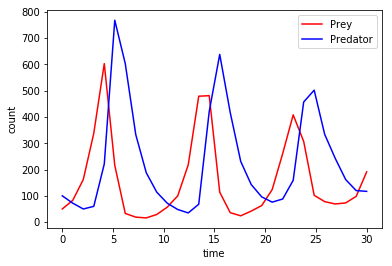

In [21]:
test_model = LotkaVolterra(parameter_values=abc_results['inferred_parameters'])
test_res = test_model.run(solver=StochKitSolver, show_labels=True)
plt.plot(test_res[0]['time'], test_res[0]['A'],'-r', label='Prey')
plt.plot(test_res[0]['time'], test_res[0]['B'],'-b', label='Predator')
plt.xlabel('time')
plt.ylabel('count')
plt.legend(loc='best')

Calculate error metrics w.r.t. inferred parameters

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
true_params = np.asarray([1.0, 0.005, 0.6])
print('Mean Absolute Error (MAE) in inferred parameters =', mean_absolute_error(true_params, np.asarray(abc_results['inferred_parameters'])))
print('Mean Absolute Percentage Error (MAPE) in inferred parameters =', mean_absolute_percentage_error(true_params, np.asarray(abc_results['inferred_parameters'])))


Mean Absolute Error (MAE) in inferred parameters = 0.039414015429397244
Mean Absolute Percentage Error (MAPE) in inferred parameters = 12.080552961602432
